# Example of running level 2 processing steps

In [1]:
from earthscopestraintools.mseed_tools import ts_from_mseed
from earthscopestraintools.gtsm_metadata import GtsmMetadata
from earthscopestraintools.timeseries import plot_timeseries_comparison

import logging
logger = logging.getLogger()
logging.basicConfig(
        format="%(message)s", level=logging.INFO
    )

### Download 1hz counts, downsample to 300s and convert to microstrain

In [2]:
#define the network and station using FDSN codes, then load the metadata for that station
network = 'PB'
station = 'B004'
meta = GtsmMetadata(network,station)

PB B004 Loading T0 LS* from 2023-01-01T00:00:00 to 2023-02-01T00:00:00 from Earthscope DMC miniseed
    Trace 1. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping LS1 to CH0
    Trace 2. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping LS2 to CH1
    Trace 3. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping LS3 to CH2
    Trace 4. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping LS4 to CH3
    Found 0 epochs with nans, 1644.75 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.06%
Converting missing data from 999999 to nan
  Converting 999999 values to nan
    Found 1644 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.06%
PB.B004.T0.LS*
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-01-01 00:00:00 - 2023-02-01 00:00:00        | Period:             1s
    | Series:         raw| Units:        counts| Level:          0| Gaps:         

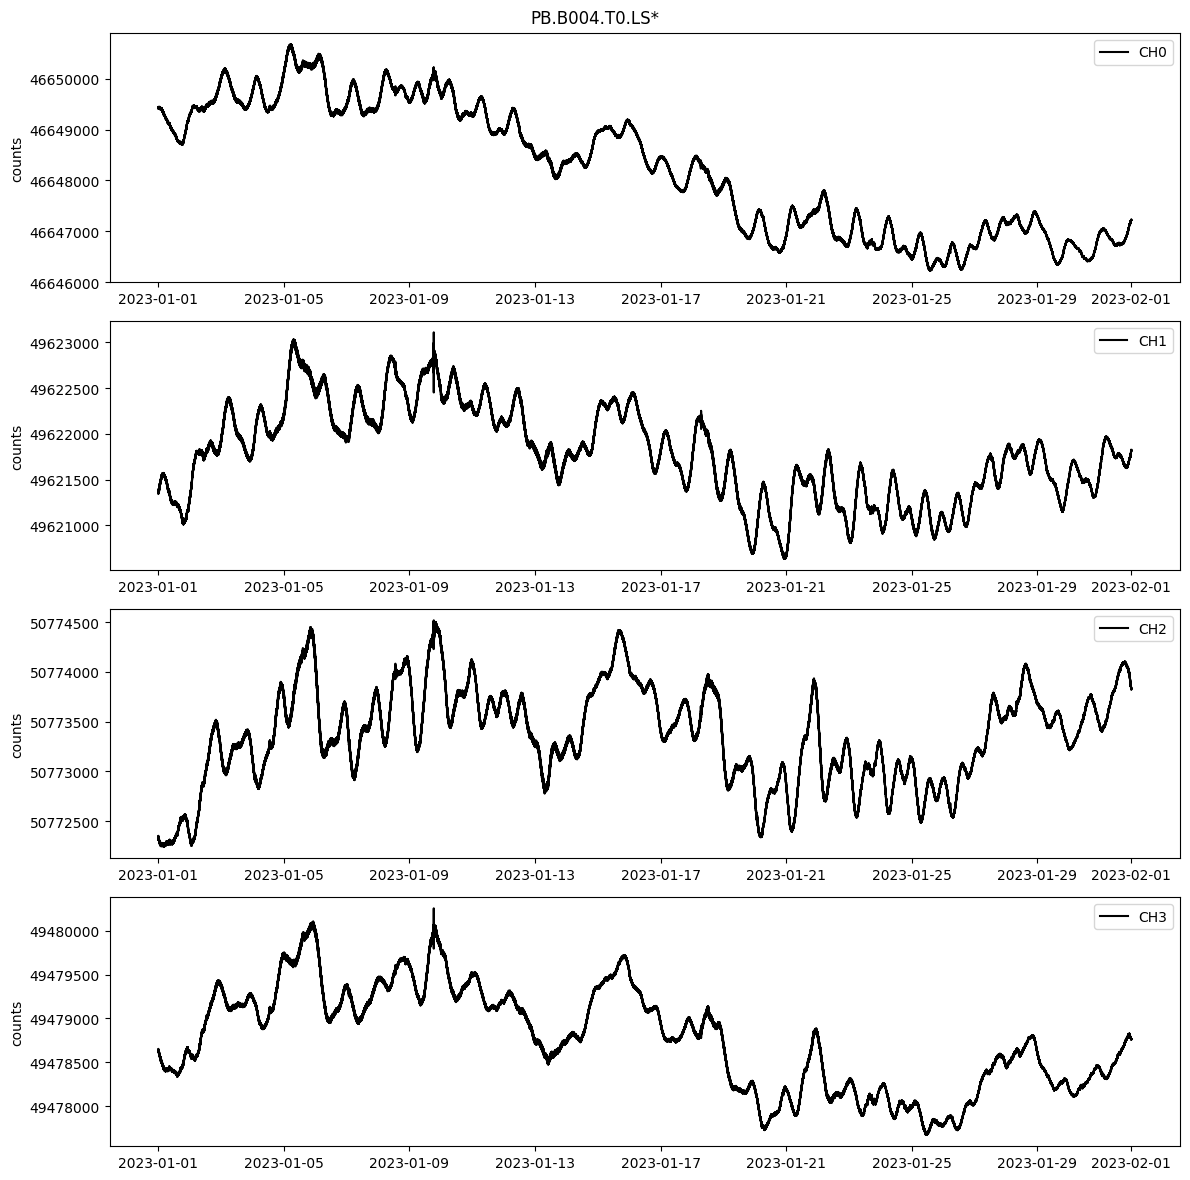

In [3]:
#provide the start and end times, as well as the FDSN location and channel codes for 1hz strain data
start="2023-01-01T00:00:00"
end = "2023-02-01T00:00:00"
#ts_from_mseed will load data into a earthscopestraintools.timeseres.Timeseries object via obspy and dataselect
strain_raw = ts_from_mseed(network=network, station=station, location='T0', channel='LS*', start=start, end=end)

#print some stats and plot the data
strain_raw.stats()
strain_raw.plot(type='line')

In [4]:
#calculate a 300s decimated Timeseries of raw counts
decimated_counts = strain_raw.decimate_1s_to_300s()

Decimating to 300s
Interpolating data using method=linear and limit=3600
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


Converting raw counts to microstrain
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B004.gauge.microstrain
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-01-01 00:00:00 - 2023-02-01 00:00:00        | Period:           300s
    | Series: microstrain| Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        8929| Good:         8928.0| Missing:      0.0| Interpolated:      1.0
    | Samples:      35716| Good:          35712| Missing:        0| Interpolated:        4


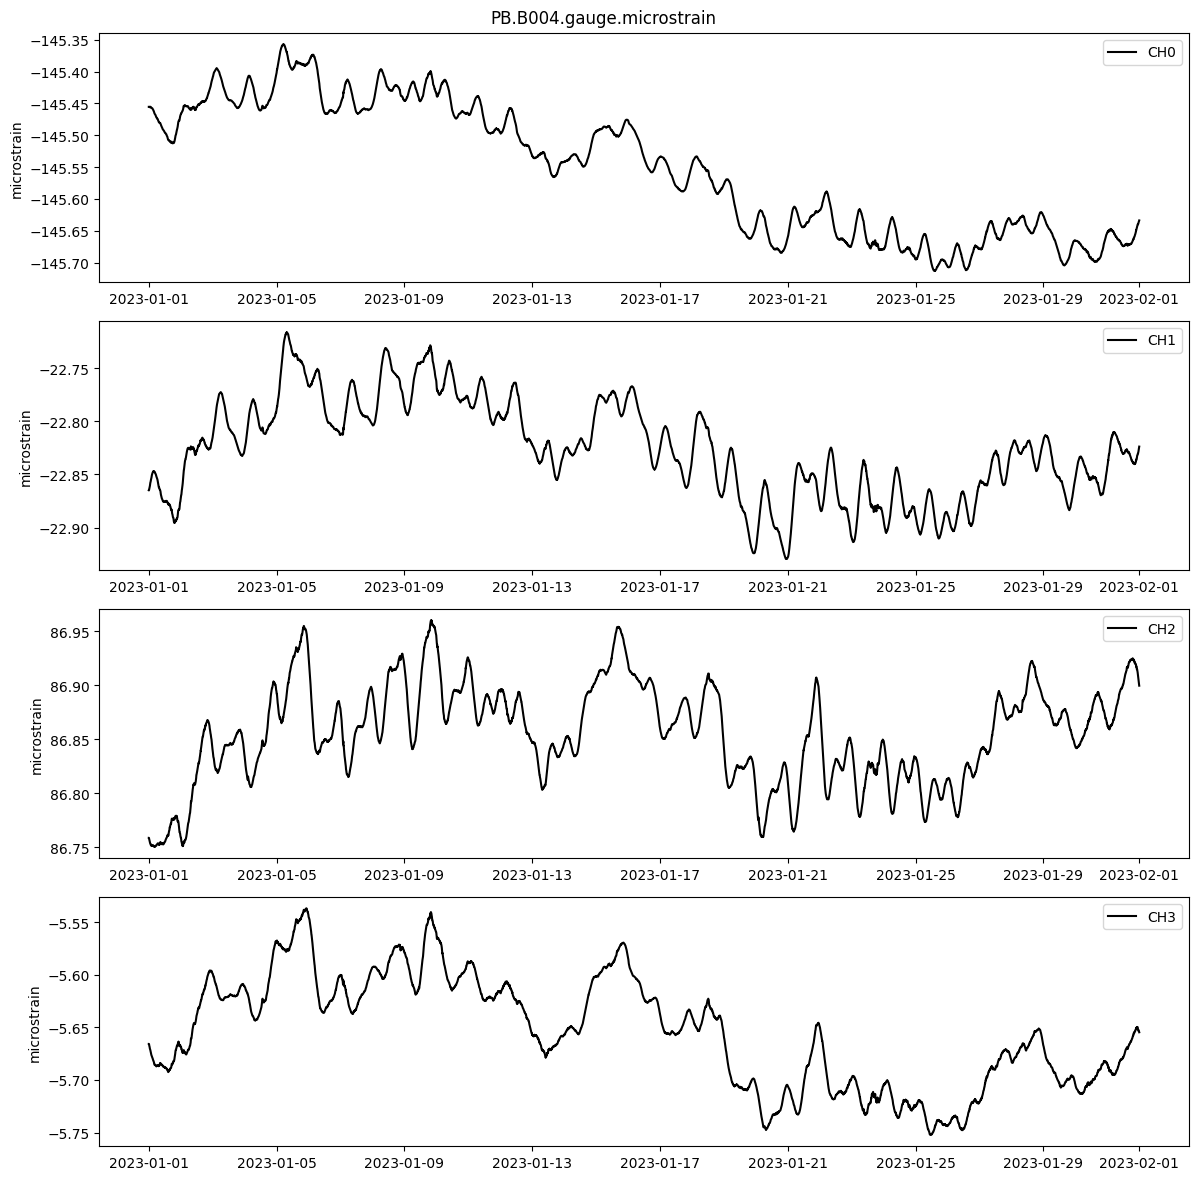

In [5]:
#convert the decimated counts into units of microstrain 
name = f"{network}.{station}.gauge.microstrain"
gauge_microstrain = decimated_counts.linearize(reference_strains=meta.reference_strains, gap=meta.gap, name=name)
gauge_microstrain.stats()
gauge_microstrain.plot()

### Trend correction

Calculating linear trend correction
    Trend Start: 2023-01-01 00:00:00
    Trend Start: 2023-02-01 00:00:00
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


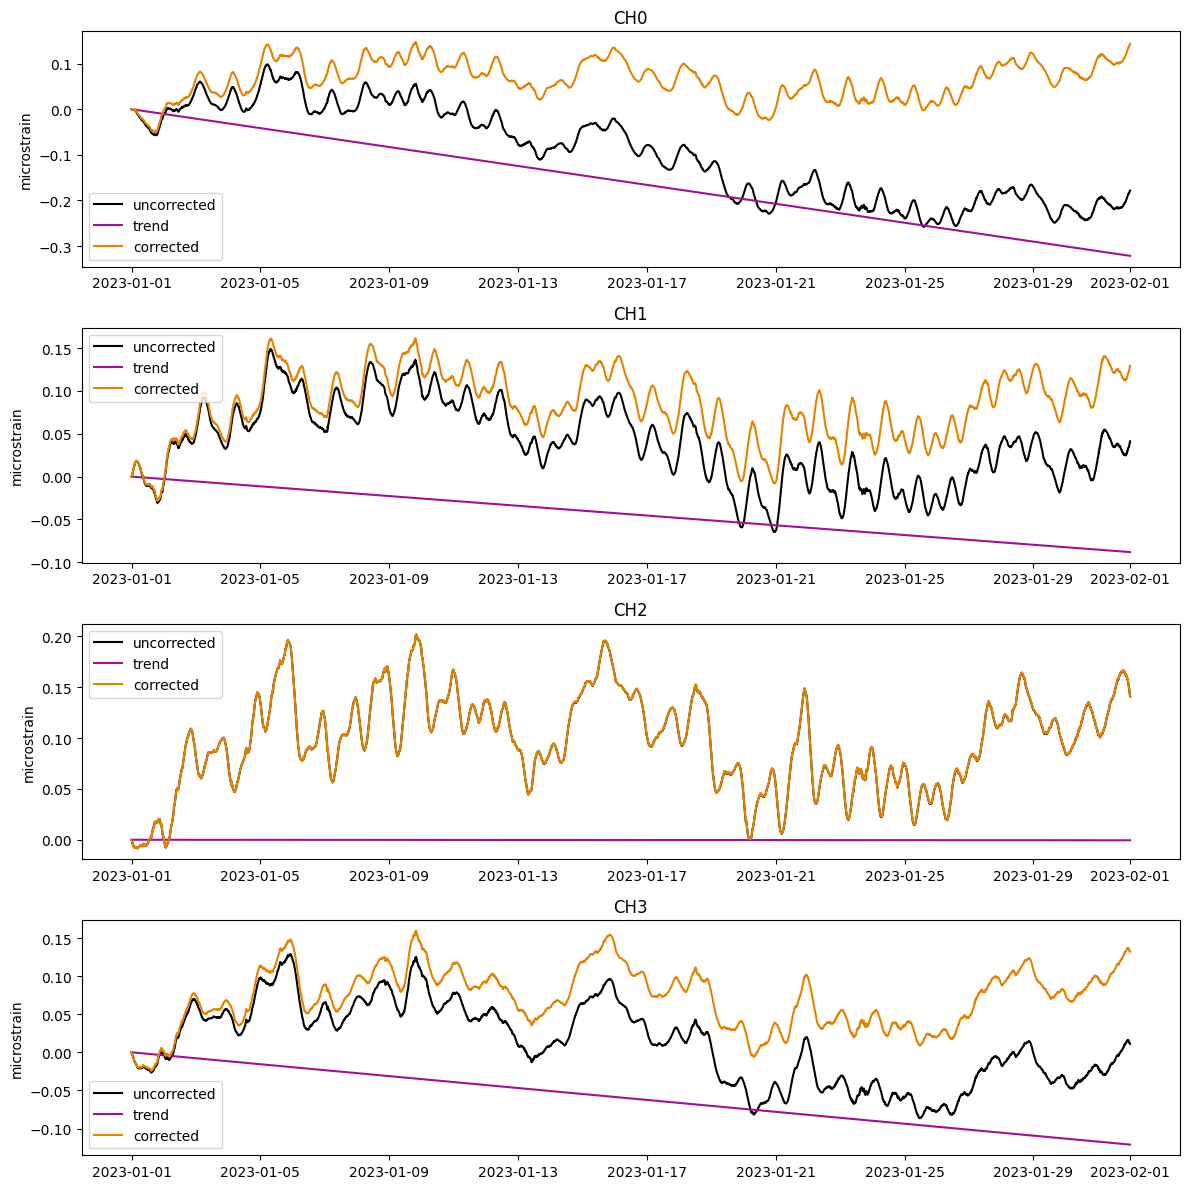

In [6]:
#calculate a linear trend correction and store it as a Timeseries
name = f"{network}.{station}.gauge.trend_c"
trend_c = gauge_microstrain.linear_trend_correction(name=name)
#create a trend corrected Timeseries
corrected = gauge_microstrain.apply_corrections([trend_c])
#compare uncorrected, trend correction, and trend corrected Timeseries
plot_timeseries_comparison([gauge_microstrain, trend_c, corrected], names=['uncorrected', 'trend', 'corrected'], zero=True)

### Tidal correction

Calculating tide correction
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


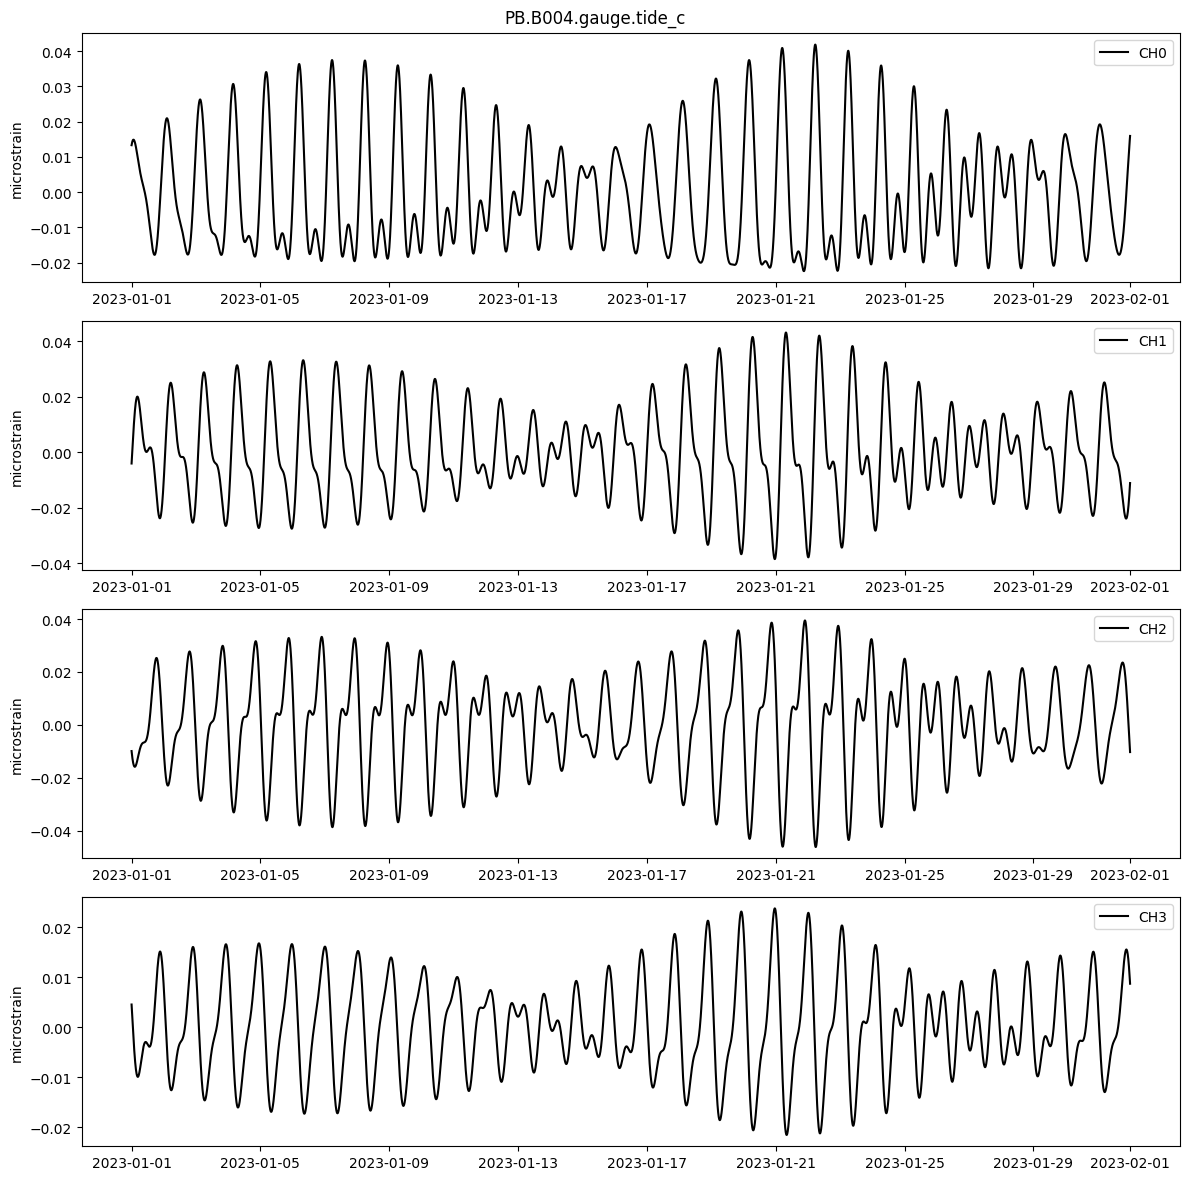

In [7]:
name = f"{network}.{station}.gauge.tide_c"
tide_c = gauge_microstrain.calculate_tide_correction(tidal_parameters=meta.tidal_params, longitude=meta.longitude, name=name)
tide_c.plot()
#tide_corrected = gauge_microstrain.apply_corrections([tide_c])
#plot_timeseries_comparison([gauge_microstrain, tide_corrected], names=['uncorrected', 'atmp_corrected'], zero=True)

### Pressure correction

PB B004 Loading * RDO from 2023-01-01T00:00:00 to 2023-02-01T00:00:00 from Earthscope DMC miniseed
    Trace 1. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping RDO to atmp
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Converting missing data from 999999 to nan
  Converting 999999 values to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Interpolating data using method=linear and limit=3600
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Calculating pressure correction
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


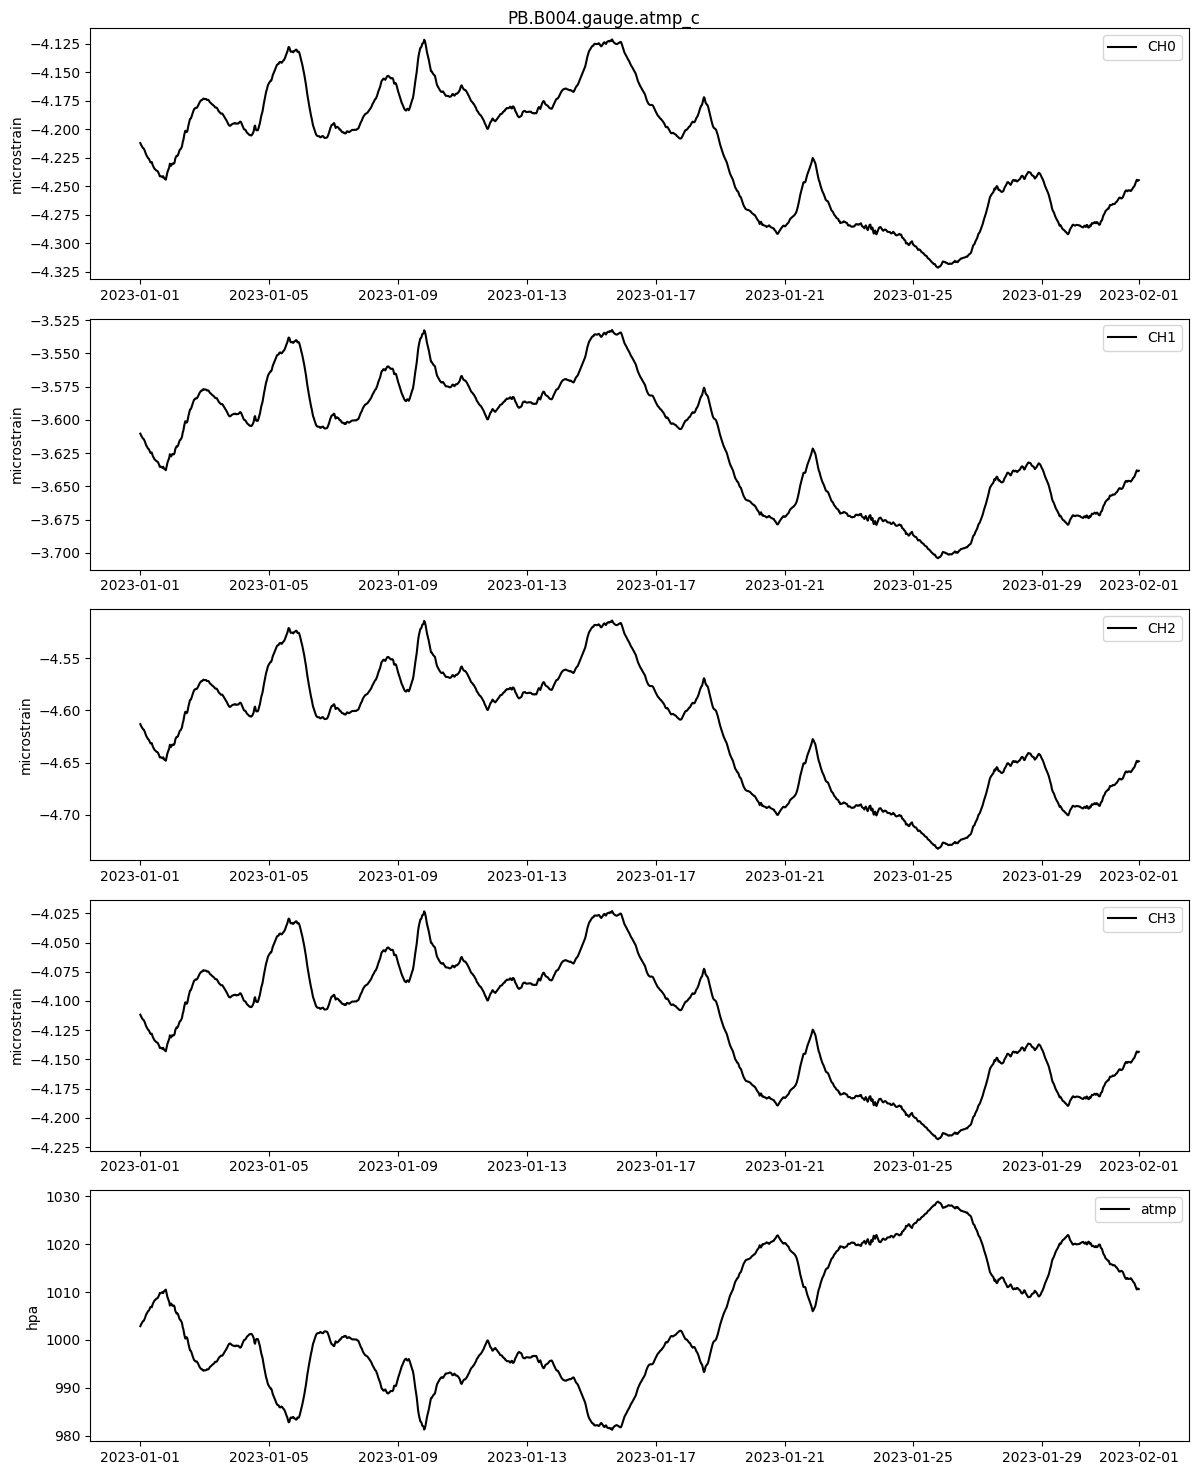

In [8]:
atmp_raw = ts_from_mseed(network=network, station=station, location='*', channel='RDO', 
                        start=start, end=end, period=60*30, scale_factor=0.001, units='hpa')
# atmp_raw.stats()
# atmp_raw.quality_stats()
# atmp_raw.plot()
atmp = atmp_raw.interpolate(new_index=strain_raw.data.index, series='hpa')
# atmp.stats()
# atmp.quality_stats()
# atmp.plot()

name = f"{network}.{station}.gauge.atmp_c"
atmp_c = atmp.calculate_pressure_correction(meta.atmp_response, name=name)
atmp_c.plot(atmp=atmp)
#atmp_corrected = gauge_microstrain.apply_corrections([atmp_c])
#atmp_corrected.plot()
#plot_timeseries_comparison([gauge_microstrain, atmp_corrected], names=['uncorrected', 'atmp_corrected'], zero=True)



### Offset correction

Calculating offsets using cutoff percentile of 0.75 and limit multiplier of 10.
Using offset limits of [0.003454, 0.00327, 0.003936, 0.002536]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


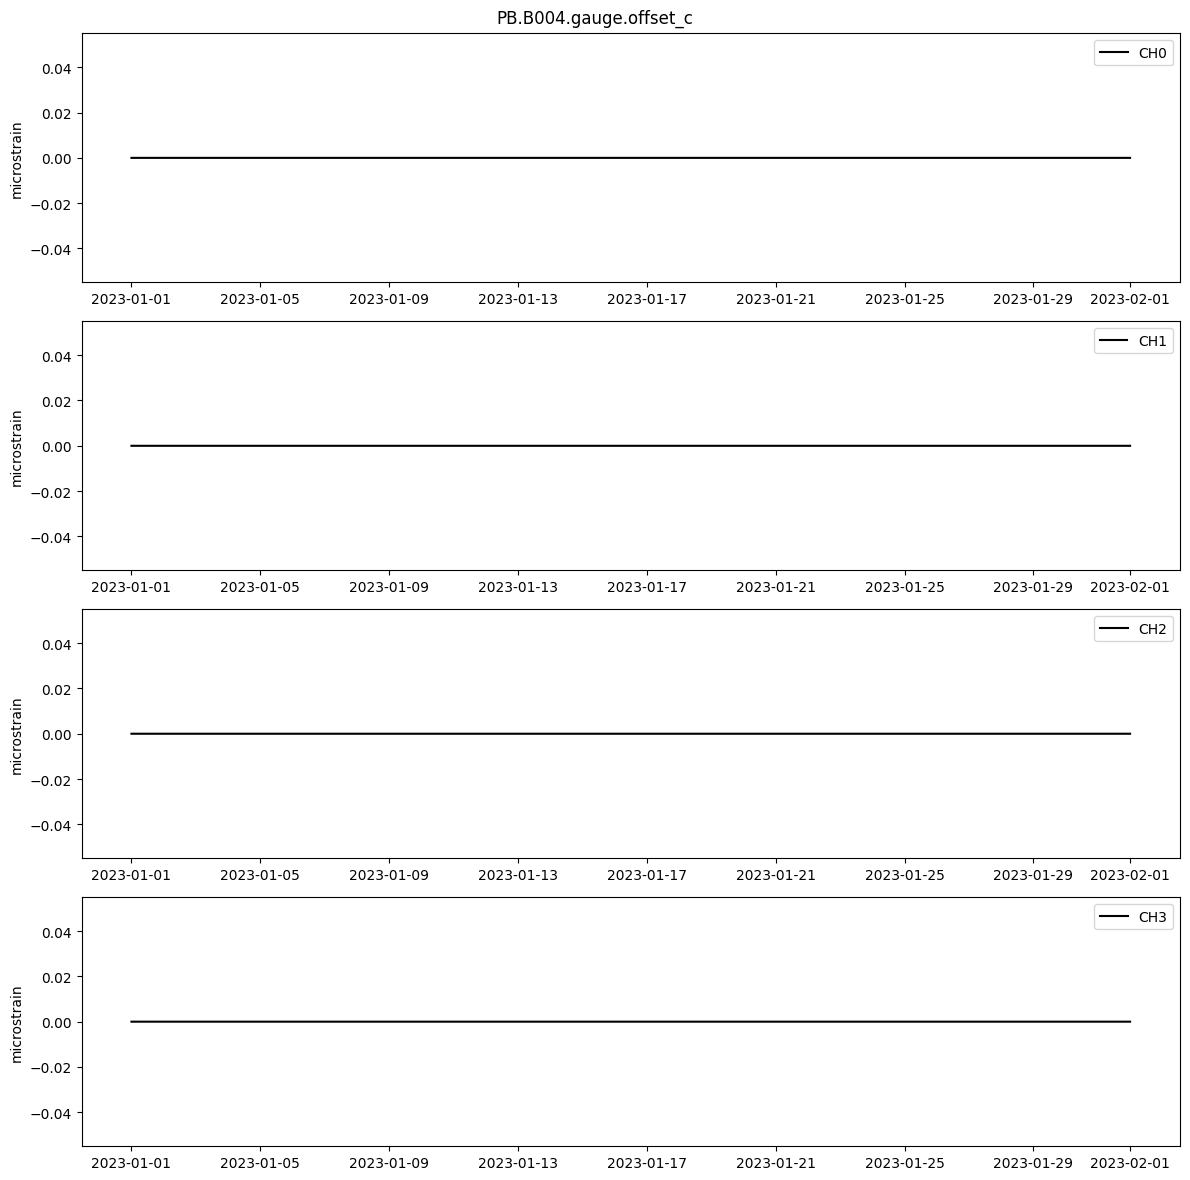

In [9]:
name = f"{network}.{station}.gauge.offset_c"
offset_c = gauge_microstrain.calculate_offsets(name=name)
offset_c.plot()

### Plot corrections

Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


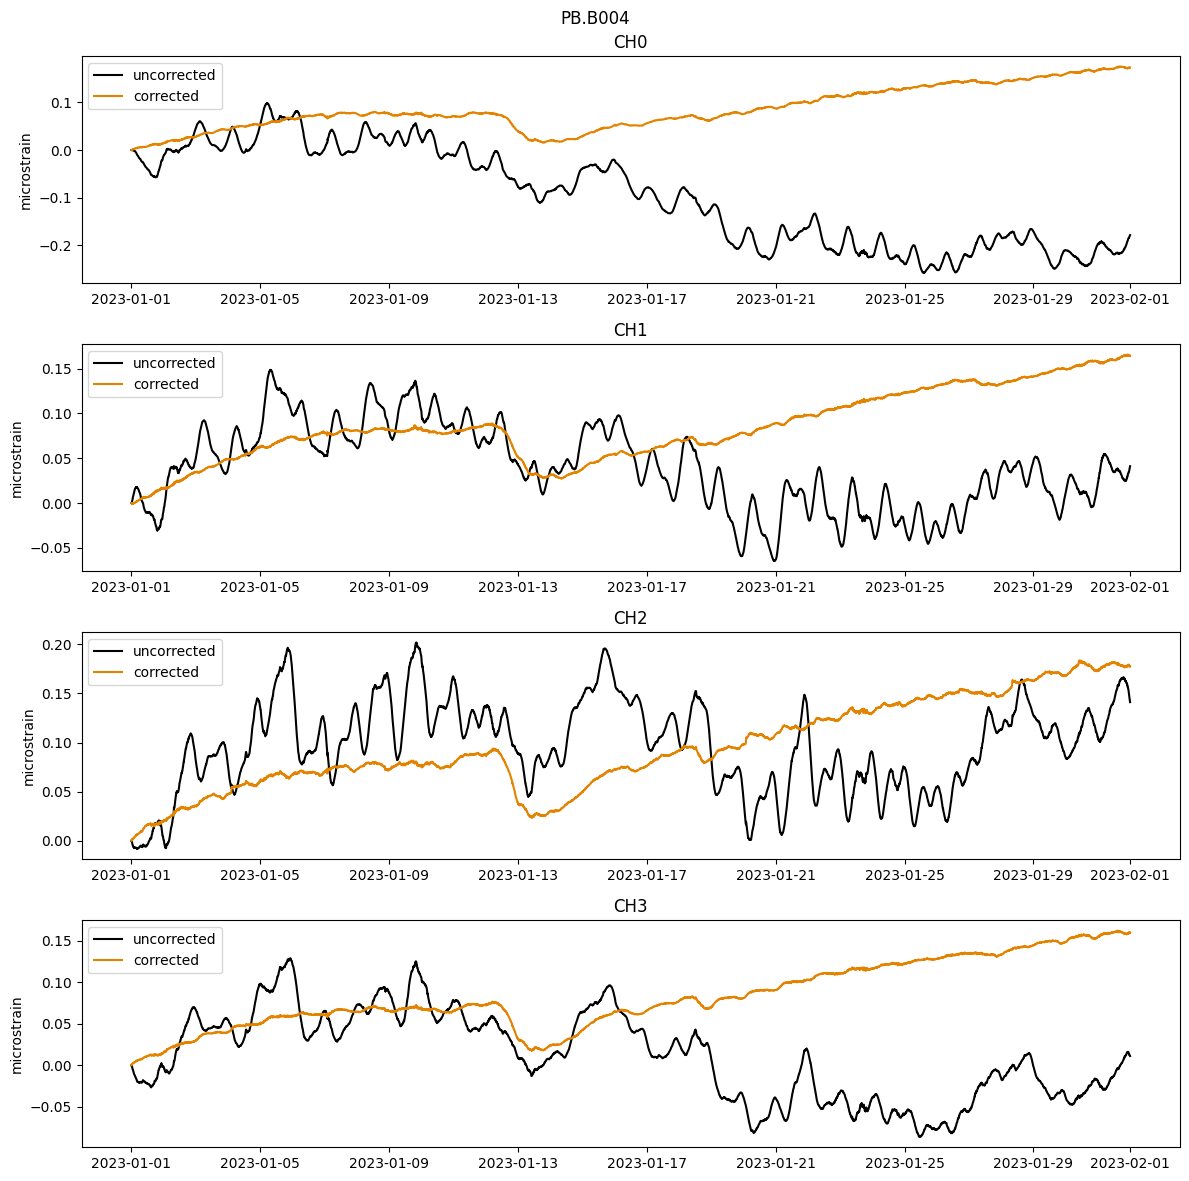

In [10]:
title=f"{network}.{station}"
gauge_corrected = gauge_microstrain.apply_corrections([tide_c, atmp_c, offset_c, trend_c])
plot_timeseries_comparison([gauge_microstrain, gauge_corrected], title=title, names=['uncorrected', 'corrected'], zero=True)

### Convert to regional strain, apply corrections

Applying None matrix: [[ 0.2967  0.5185  0.2958  0.2222]
 [-0.2887  0.2983  0.1688 -0.1784]
 [-0.266  -0.2196  0.3531  0.1325]]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B004.gauge.microstrain.calibrated
    | Channels: ['Eee+Enn', 'Eee-Enn', '2Ene']           
    | TimeRange: 2023-01-01 00:00:00 - 2023-02-01 00:00:00        | Period:           300s
    | Series: microstrain| Units:   microstrain| Level:         2a| Gaps:             0.0% 
    | Epochs:        8929| Good:         8929.0| Missing:      0.0| Interpolated:      0.0
    | Samples:      26787| Good:          26787| Missing:        0| Interpolated:        0


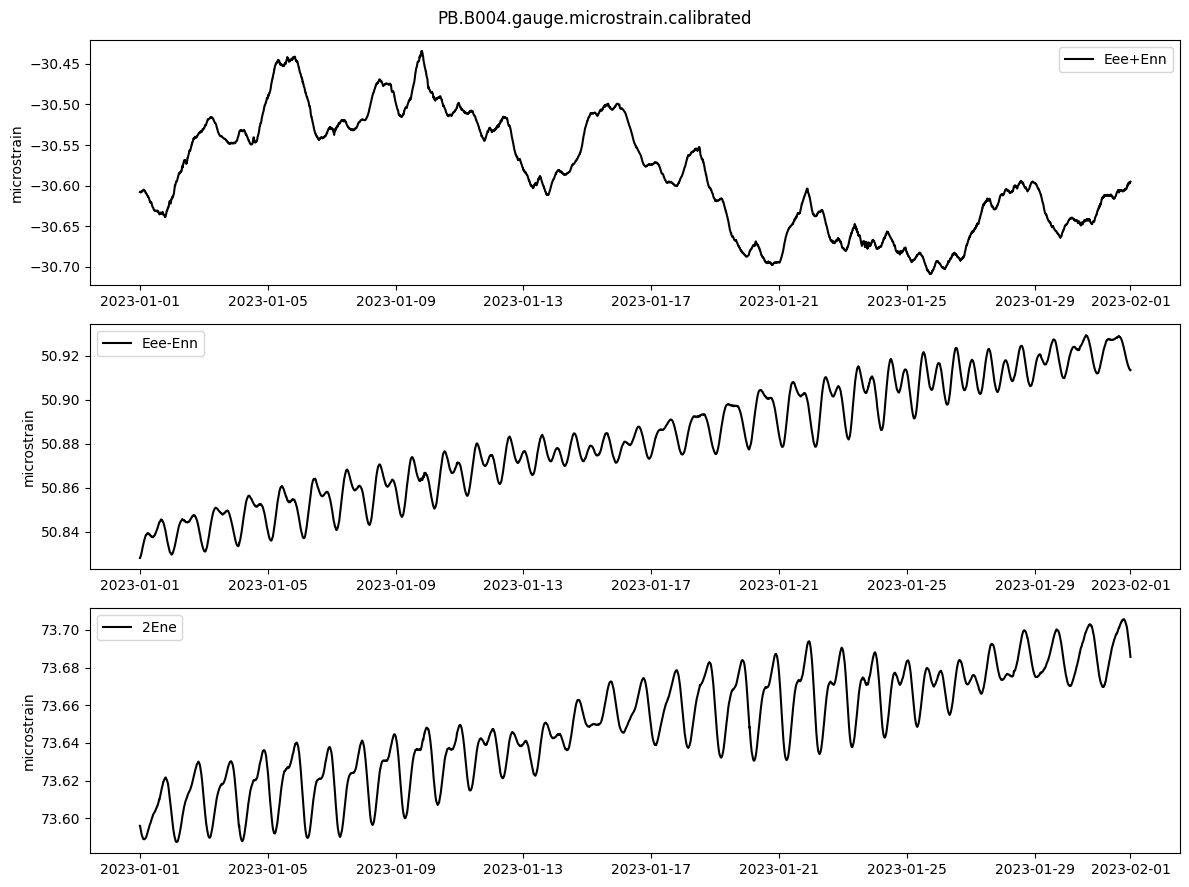

In [12]:
calibration_matrix = meta.strain_matrices['lab']
regional_microstrain = gauge_microstrain.apply_calibration_matrix(calibration_matrix)
regional_microstrain.stats()
regional_microstrain.plot()

In [13]:
regional_tide_c = tide_c.apply_calibration_matrix(calibration_matrix)
regional_trend_c = trend_c.apply_calibration_matrix(calibration_matrix)
regional_atmp_c = atmp_c.apply_calibration_matrix(calibration_matrix)
regional_offset_c = offset_c.apply_calibration_matrix(calibration_matrix)


Applying None matrix: [[ 0.2967  0.5185  0.2958  0.2222]
 [-0.2887  0.2983  0.1688 -0.1784]
 [-0.266  -0.2196  0.3531  0.1325]]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying None matrix: [[ 0.2967  0.5185  0.2958  0.2222]
 [-0.2887  0.2983  0.1688 -0.1784]
 [-0.266  -0.2196  0.3531  0.1325]]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying None matrix: [[ 0.2967  0.5185  0.2958  0.2222]
 [-0.2887  0.2983  0.1688 -0.1784]
 [-0.266  -0.2196  0.3531  0.1325]]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying None matrix: [[ 0.2967  0.5185  0.2958  0.2222]
 [-0.2887  0.2983  0.1688 -0.1784]
 [-0.266  -0.2196  0.3531  0.1325]]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


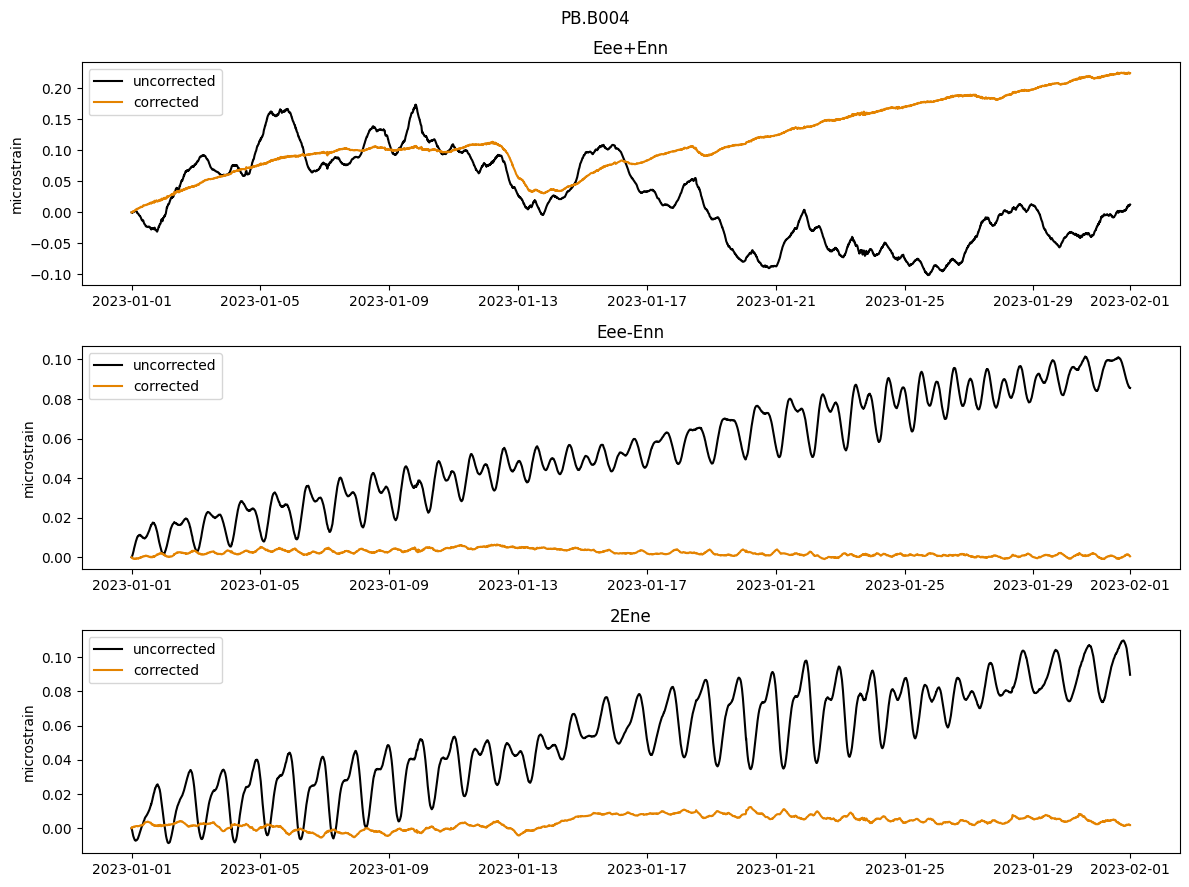

In [14]:
title=f"{network}.{station}"
regional_corrected = regional_microstrain.apply_corrections([regional_tide_c, regional_atmp_c, regional_offset_c, regional_trend_c])
plot_timeseries_comparison([regional_microstrain, regional_corrected], title=title, names=['uncorrected', 'corrected'], zero=True)

### Plot corrected data against rainfall data

PB B004 Loading * RRO from 2023-01-01T00:00:00 to 2023-02-01T00:00:00 from Earthscope DMC miniseed
    Trace 1. 2023-01-01T00:00:00.000000Z:2023-02-01T00:00:00.000000Z mapping RRO to rain
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Converting missing data from 999999 to nan
  Converting 999999 values to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B004.gauge.microstrain.calibrated.corrected
    | Channels: ['Eee+Enn', 'Eee-Enn', '2Ene']           
    | TimeRange: 2023-01-01 00:00:00 - 2023-02-01 00:00:00        | Period:           300s
    | Series:   corrected| Units:   microstrain| Level:         2a| Gaps:             0.0% 
    | Epochs:        8929| Good:         8929.0| Missing:      0.0| Interpolated:      0.0
    | Samples:      26787| Good:          26787| Missing:        0| Interpolated:        0


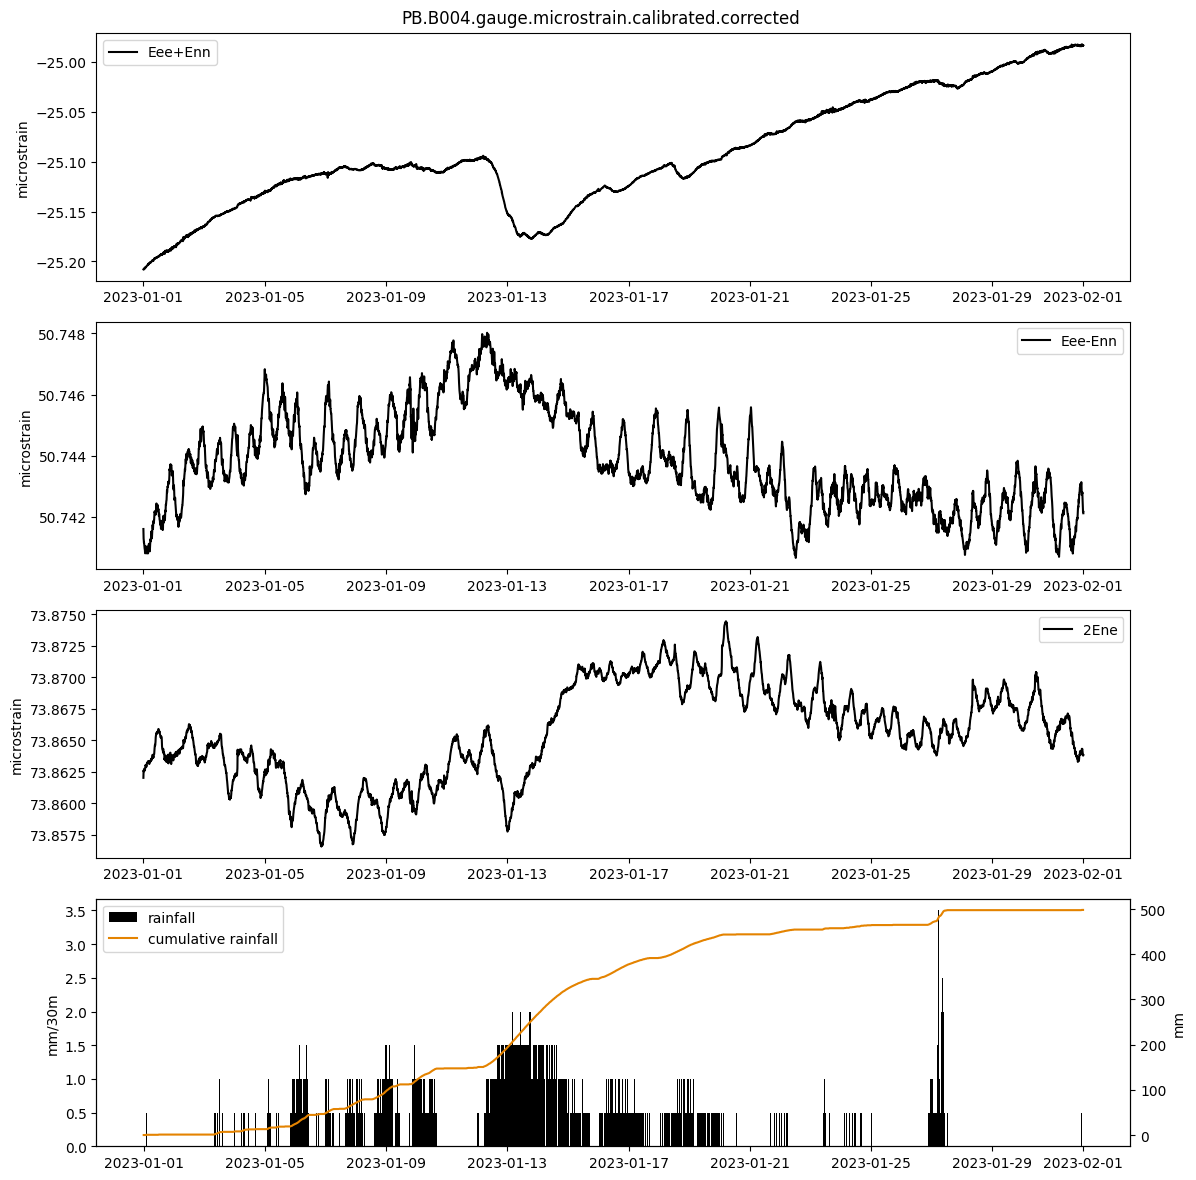

In [15]:
rainfall = ts_from_mseed(network=network, station=station, location='*', channel='RRO', 
                         start=start, end=end, period=60*30, scale_factor=0.0001, units='mm/30m')
regional_corrected.plot(rainfall=rainfall)
regional_corrected.stats()